# 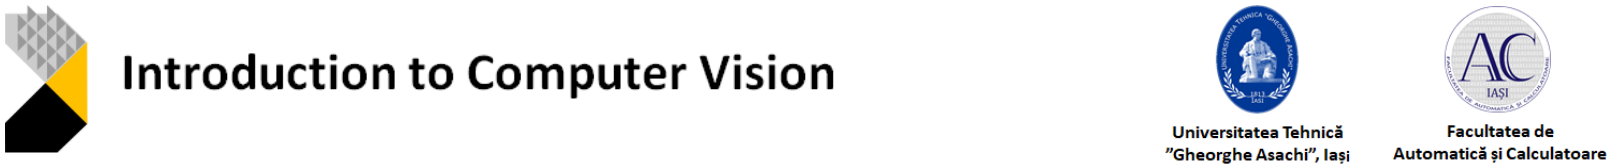

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 1: Lane Detection

In the field of Computer Vision, extraction of geometric features from images is a common problem. Different approaches have been proven to be efficient in extracting particular features as part of the solution. Some solutions involve global examination of the input image, while others involve local examination at pixel level. A basic feature of any self-driving system is Lane Detection.

####Key takeaways for project 1:
1. Use Gaussian Blur to remove all noise from the image
2. Use canny edge detection to isolate edges in the image
3. Use Bitwise And function to isolate edges which correspond to the lane lines
4. Use Hough Transform to turn the edges into lines

## Week 1: edge detection
## Week 2: fitting lines using Hough Transform

## Week 3: evaluate performance of our pipeline

###Evaluation metrics:
When trying out different methods, how do you know which one is best? If you have a ground truth or gold standard segmentation, you can use various metrics to check how close each automated method comes to the truth.
<figure>
<img src='https://drive.google.com/uc?id=1R2lZ6ZJe-gvXnxBox6senKWStQo1lIXB' width="250">
<img src='https://drive.google.com/uc?id=1CRkk4G6VSDS77uVwZWPQ5XBNqVi3Jg0_' width="400">
</figure>

* TP is the number of true positives
* TN is the number of true negatives
* FN is the number of false negatives
* FP is the number of false positives
---
1. **Pixel accuracy** - the percent of pixels in the image that are classified correctly
  $Pixel_{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
---
2. **Mean IoU** (Mean Intersection over Union) 
  
  This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.

  $IoU = \frac{TP}{TP + FP + FN}$
<figure>
<img src='https://drive.google.com/uc?id=1J9keMNZ-R2r_JuCr7gtLUwPGTPBL8BOM' width="270">
</figure>
---
3. **Precision** - a metric of exactness or quality
  
  $Precision = \frac{TP}{TP + FP}$
<figure>
<img src='https://drive.google.com/uc?id=1EYIEn7-Sqnw1-kC5CI-IIKeAV5kWYGZ_' width="200">
</figure>
---
4. **Recall** - a metric of completeness or quantity

  $Recall = \frac{TP }{TP + FN}$
<figure>
<img src='https://drive.google.com/uc?id=1gOh9rrI7Y7bLFiqk_hFW2Z9ATR03cKaD' width="180">
</figure>
The scores of precision and recall should be both high, but there is an inverse relationship between precision and recall, where it is possible to increase one at the cost of reducing the other.
---
5. **F-measure**, also known as Sørensen–Dice coefficient or Dice similarity coefficient

  $F-measure = \frac{2*Recall*Precision}{Recall + Precision}$

  The F-Measure which is a harmonic mean of precision and recall can be viewed as a compromise between precision and recall. It balances the precision and recall with equal weights, and it is high only when both recall and precision are high. A higher score of F-Measure means that the performance of the algorithm is better.



In [31]:
import os

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# last week's pipeline and functions (grayscale, gaussian_smoothing, canny_detector, region_of_interest, overlap, draw_lines, slope_lines, hough_lines)

def grayscale(img):
  #code here
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return gray

# 2. gaussian smoothing
def gaussian_smoothing(img, kernel_size):
  #code here
  smoothed_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
  return smoothed_img

# 3. Canny edge detection
def canny_detector(img, low_threshold, high_threshold):
  #code here
  canny_edges = cv2.Canny(img, low_threshold, high_threshold)
  return canny_edges

# 4. Region of Interest: define vertices, create the mask (trapeze), apply the mask to Canny edges
def region_of_interest(img):
  #code here
  rows, cols = img.shape[:2]
  
  A = [0.3*cols, rows]
  B = [cols*0.5, rows*0.3]
  C = [0.7*cols, rows]
  vertices = np.array([[A, B, C]], dtype=np.int32)

  # defining a blank mask to start with
  mask = np.zeros_like(img)
  ignore_mask_color = 255  # filling pixels inside the polygon defined by "vertices" with the fill color    
  
  cv2.fillPoly(mask, vertices, ignore_mask_color)
  
  masked_edges = cv2.bitwise_and(img, mask)
  return masked_edges

# 5. Overlap two images
def overlap(img, a, initial_img, b, c):
  #code here
  edges_over_gray = cv2.addWeighted(img, a, initial_img, b, c)
  return edges_over_gray

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            #TODO: draw a line on the image - see cv2.line
            #code here
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# this function calculates only one left line and one right line as a mean of the multiple left lines, respectively multiple right lines
# it uses the line equation with slope y = m*x + n to determine which are / and which \
# at the end the two lines are drawn on the input image
def slope_lines(image, lines):
    
    #copy input for result
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                #slope of a line crossing A(x1, y2), B(x2, y2)
                m = (y2 - y1) / (x2 - x1) 
                #we know that equation of line is y = m*x + n so we can write n = y - m*x
                n = y1 - m * x1

                if m < 0:
                    left_lines.append((m,n))
                elif m >= 0:
                    right_lines.append((m,n))

    #arithmetic mean to get only one (m, n) coefficients for left '/' and right '\' lines
    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #for both left & right lines compute the 2 points describing a line
    #the 2 segments are from the bottom to 60% of the height
    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +n so we can write it x=(y-n)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        #draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    #vertices of the two lines (looking like: / \ )
    poly_vertices = [poly_vertices[i] for i in order]

    #fill with color between left and right line
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))

    #overlap to original
    return overlap(image, 0.7, img, 0.4, 0.)

# Function to extract hough lines and draw them on a blank (white) image
def hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_length=20, max_line_gap=180):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    #TODO: extract Hough lines - see cv2.HoughLinesP
    #code here
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    #blank image (on 3 channels) the same size as input image to draw the lines on
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    #TODO: draw lines on the blank image and return - use draw_lines function defined above
    #code here
    line_img = slope_lines(line_img, lines)

    return line_img

# 6. our pipeline as a function
def our_pipeline(image):
    #Grayscale
    #code here
    gray_img = grayscale(image)

    #Gaussian Smoothing
    #code here
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    smoothed_img = gaussian_smoothing(gray_img, kernel_size)

    #Canny Edge Detection
    #code here
    #parameters
    low_threshold = 180
    high_threshold = 240
    canny_img = canny_detector(smoothed_img, low_threshold, high_threshold)

    #Masked Image Within a Polygon
    masked_edges = region_of_interest(canny_img)

    houghed_lines = hough_lines(masked_edges)

    #a = 0.8
    #b = 1
    #c = 0.    
    #output = overlap(houghed_lines, a, image, b, c)

    return houghed_lines

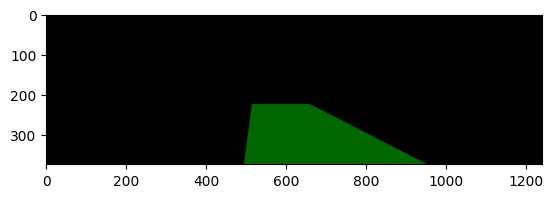

In [3]:
#TODO: read image - see cv2.imread
#code here
# Read image
image = cv2.imread('um_000000.png')

#BGR to RBG
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#pipeline without overlapping to input image
houghed_lines = our_pipeline(image)

#print result - see plt.imshow
plt.imshow(houghed_lines, cmap='gray')

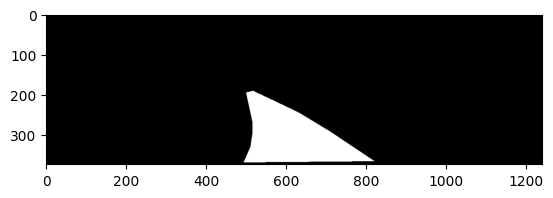

In [4]:
#TODO: add GT image at https://drive.google.com/file/d/1D1pG7nR8YoheqbPuaLe6G6dSi2r4A33F/view?usp=sharing to My Drive

# Read GT image
GT_image = cv2.imread('um_lane_000000.png')

# BGR to HSV
GT_image = cv2.cvtColor(GT_image, cv2.COLOR_BGR2HSV)

# Function to filter the color for lane annotation (magenta) in HSV
def truth_lane(img):
    # Define magenta color
    magenta = np.uint8([[[255, 0, 255]]])

    # Convert magenta to HSV
    hsv_magenta = cv2.cvtColor(magenta, cv2.COLOR_BGR2HSV)

    # Define the interval to filter magenta
    hsv_color1 = np.array([140, 100, 100])
    hsv_color2 = np.array([180, 255, 255])

    # Filter by H value
    mask = cv2.inRange(img, hsv_color1, hsv_color2)

    return mask

# Apply function
GT_lane = truth_lane(GT_image)

# Print GT lane
plt.imshow(GT_lane, cmap='gray')
plt.show()

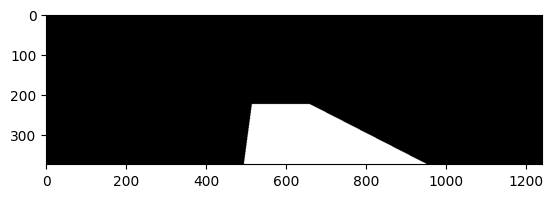

In [5]:
# our detected lane
# BRG to gray
detections = cv2.cvtColor(houghed_lines, cv2.COLOR_BGR2GRAY)
ret,detections = cv2.threshold(detections,50,255,cv2.THRESH_BINARY)
plt.imshow(detections, cmap='gray')

Take a look at the computation of TP, FP, FN, TN in C++ using OpenCV
```
struct result_t { int TP;  
                  int FP;  
                  int FN;  
                  int TN; };  

result_t conf_mat_2c(cv::Mat1b truth, cv::Mat1b detections) {  
  CV_Assert(truth.size == detections.size);  
  result_t result = { 0 };  
  cv::Mat inv_truth(~truth);  
  cv::Mat inv_detections(~detections);  
  cv::Mat temp;  
  cv::bitwise_and(detections, truth, temp);  
  result.TP = cv::countNonZero(temp);  
  cv::bitwise_and(detections, inv_truth, temp);  
  result.FP = cv::countNonZero(temp);  
  cv::bitwise_and(inv_detections, truth, temp);  
  result.FN = cv::countNonZero(temp);  
  cv::bitwise_and(inv_detections, inv_truth, temp);  
  result.TN = cv::countNonZero(temp);  
  return result;  
}
```

29126


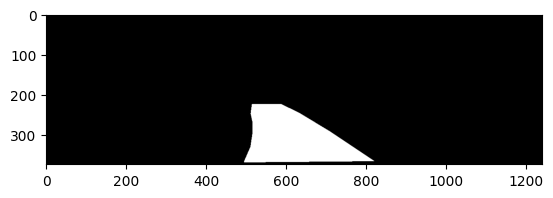

In [6]:
#compute TP - use cv2.bitwise_and, cv2.countNonZero
TP = cv2.bitwise_and(detections, GT_lane)
#count TP pixels
tp = cv2.countNonZero(TP)
#image TP
plt.imshow(TP, cmap='gray')
#pixel no of TP
print(tp)

16094


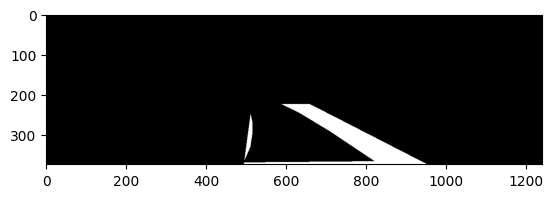

In [7]:
#TODO: compute FP - use cv2.bitwise_and, cv2.bitwise_not
#code here
# Compute FP - False Positives
FP = cv2.bitwise_and(cv2.bitwise_not(GT_lane), detections)

#TODO: count FP pixels - cv2.countNonZero
#code here
fp = cv2.countNonZero(FP)

#image FP
plt.imshow(FP, cmap='gray')
#pixel no of FP
print(fp)

1717


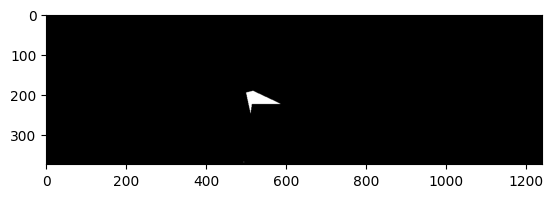

In [8]:
#TODO: compute FN - use cv2.bitwise_and, cv2.bitwise_not
#code here
# Compute FN - False Negatives
FN = cv2.bitwise_and(cv2.bitwise_not(detections), GT_lane)

#TODO: count FN pixels - cv2.countNonZero
#code here
fn = cv2.countNonZero(FN)

#image FN
plt.imshow(FN, cmap='gray')
#pixel no of FN
print(fn)

418813


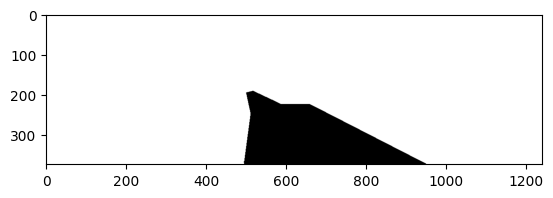

In [9]:
#TODO: compute TN - use cv2.bitwise_and, cv2.bitwise_not
#code here
# Compute TN - True Negatives
TN = cv2.bitwise_and(cv2.bitwise_not(GT_lane), cv2.bitwise_not(detections))

#TODO: count TN pixels - cv2.countNonZero
#code here
tn = cv2.countNonZero(TN)

#image TN
plt.imshow(TN, cmap='gray')
#pixel no of TN
print(tn)

In [35]:
#TODO: define a function to count pixel number of TP, FP, TN, FN
def TP_FP_TN_FN(detections, truth):
    # Convert images to binary format
    _, detections = cv2.threshold(detections, 0, 255, cv2.THRESH_BINARY)
    _, truth = cv2.threshold(truth, 0, 255, cv2.THRESH_BINARY)

    # Ensure both images have the same dimensions
    min_height = min(detections.shape[0], truth.shape[0])
    min_width = min(detections.shape[1], truth.shape[1])
    detections = detections[:min_height, :min_width]
    truth = truth[:min_height, :min_width]

    # Compute TP - True Positives
    TP = cv2.bitwise_and(detections, truth)
    tp = cv2.countNonZero(TP)

    # Compute FP - False Positives
    FP = cv2.bitwise_and(cv2.bitwise_not(truth), detections)
    fp = cv2.countNonZero(FP)

    # Compute FN - False Negatives
    FN = cv2.bitwise_and(cv2.bitwise_not(detections), truth)
    fn = cv2.countNonZero(FN)

    # Compute TN - True Negatives
    TN = cv2.bitwise_and(cv2.bitwise_not(truth), cv2.bitwise_not(detections))
    tn = cv2.countNonZero(TN)

    return tp, fp, tn, fn


**Pixel accuracy** - the percent of pixels in the image that are classified correctly
  $Pixel_{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

In [20]:
#TODO: compute pixel accuracy
#code here
def compute_pixel_accuracy(tp, fp, tn, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy

# Compute pixel accuracy
accuracy = compute_pixel_accuracy(tp, fp, tn, fn)

print(accuracy*100)

96.17584541062803


**Mean IoU** (Mean Intersection over Union) 
  
  This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.

  $IoU = \frac{TP}{TP + FP + FN}$
<figure>
<img src='https://drive.google.com/uc?id=1J9keMNZ-R2r_JuCr7gtLUwPGTPBL8BOM' width="270">
</figure>

In [21]:
def compute_iou(tp, fp, fn):
    iou = tp / (tp + fp + fn)
    return iou

# Compute Mean IoU
iou = compute_iou(tp, fp, fn)

# Print Mean IoU
print("Mean IoU:", iou * 100)

Mean IoU: 62.05339071521401


**Precision** - a metric of exactness or quality
  
  $Precision = \frac{TP}{TP + FP}$
<figure>
<img src='https://drive.google.com/uc?id=1EYIEn7-Sqnw1-kC5CI-IIKeAV5kWYGZ_' width="200">
</figure>


In [22]:
def compute_precision(tp, fp):
    precision = tp / (tp + fp)
    return precision

# Compute Precision
precision = compute_precision(tp, fp)

# Print Precision
print("Precision:", precision * 100)

Precision: 64.40955329500221


**Recall** - a metric of completeness or quantity

  $Recall = \frac{TP }{TP + FN}$
<figure>
<img src='https://drive.google.com/uc?id=1gOh9rrI7Y7bLFiqk_hFW2Z9ATR03cKaD' width="180">
</figure>
The scores of precision and recall should be both high, but there is an inverse relationship between precision and recall, where it is possible to increase one at the cost of reducing the other.

In [23]:
def compute_recall(tp, fn):
    recall = tp / (tp + fn)
    return recall

# Compute Recall
recall = compute_recall(tp, fn)

# Print Recall
print("Recall:", recall * 100)

Recall: 94.43309665077976


**F-measure**, also known as Sørensen–Dice coefficient or Dice similarity coefficient

  $F-measure = \frac{2*Recall*Precision}{Recall + Precision}$

  The F-Measure which is a harmonic mean of precision and recall can be viewed as a compromise between precision and recall. It balances the precision and recall with equal weights, and it is high only when both recall and precision are high. A higher score of F-Measure means that the performance of the algorithm is better.

In [24]:
def compute_f_measure(precision, recall):
    f_measure = 2 * (precision * recall) / (precision + recall)
    return f_measure

# Compute F-measure
f_measure = compute_f_measure(precision, recall)

# Print F-measure
print("F-measure:", f_measure)

F-measure: 0.7658388441160616


In [25]:
def compute_metrics(tp, fp, tn, fn):
    # Compute pixel accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100

    # Compute Mean IoU
    iou = tp / (tp + fp + fn) * 100

    # Compute Precision
    precision = tp / (tp + fp) * 100

    # Compute Recall
    recall = tp / (tp + fn) * 100

    # Compute F-measure
    f_measure = 2 * (precision * recall) / (precision + recall)

    return accuracy, iou, precision, recall, f_measure

# Example usage:
accuracy, iou, precision, recall, f_measure = compute_metrics(tp, fp, tn, fn)


In [ ]:
#TODO: add image at https://drive.google.com/file/d/1npaQZlnl5Xlyw6t2Sql_v4QAUiN4vsRY/view?usp=sharing to My Drive
#TODO: add ground truth at https://drive.google.com/file/d/1YpOSp2-1Tk-Ai6IBJEUoQPCaLzxeLTYs/view?usp=sharing to My Drive

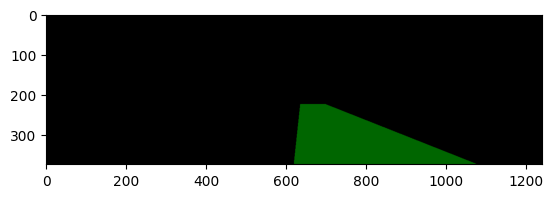

In [26]:
#TODO: read image and apply our_pipeline

#read image 
image = cv2.imread('um_000001.png')

#BGR to RBG
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

#pipeline without overlapping to input image
houghed_lines = our_pipeline(image)

#print result - see plt.imshow
plt.imshow(houghed_lines, cmap='gray')

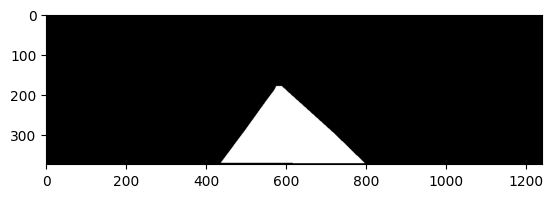

In [27]:
#read GT image and apply truth_lane
image = cv2.imread('um_lane_000001.png')
#BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#TODO: filter the lane - truth_lane()
#code here
image_lane = truth_lane(image)

#TODO: print lane
#code here
plt.imshow(image_lane, cmap='gray')

In [28]:
#compute evaluation metrics for 2nd image
tp, fp, tn, fn = TP_FP_TN_FN(detections, image_lane)
print(compute_metrics(tp, fp, tn, fn))

(95.82973698336016, 61.46077225286718, 68.49845201238391, 85.67753713384782, 76.13090337089699)


In [ ]:
#TODO: apply pipeline and compute metrics to a dataset with Ground Truth annotation 
#images are available at https://drive.google.com/drive/folders/1yuq8kJaVY6TKRU93ahVbsz-l7aT-Azuy?usp=sharing
#ground truth is available at https://drive.google.com/drive/folders/1fmWB21Nv6yeyPSlFqnU_T6956bpCfk52?usp=sharing

In [38]:
# Path to the folders containing images and ground truth annotations
image_folder_path = 'image'
gt_folder_path = 'gt_image'

# Function to read and process images
def process_images(image_path, gt_image_path):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to match ground truth image dimensions
    gt_image = cv2.imread(gt_image_path)
    gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2HSV)
    image = cv2.resize(image, (gt_image.shape[1], gt_image.shape[0]))

    # Apply pipeline
    houghed_lines = our_pipeline(image)

    # Filter the lane
    gt_lane = truth_lane(gt_image)

    return houghed_lines, gt_lane


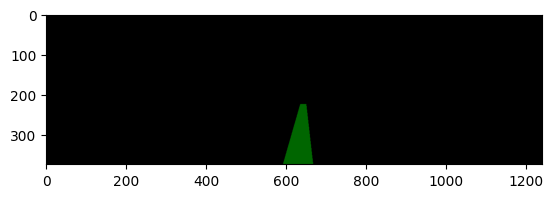

In [39]:
#TODO: read image and apply our_pipeline

#read image 
image = cv2.imread('image/um_000002.png')

#BGR to RBG
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

#pipeline without overlapping to input image
houghed_lines = our_pipeline(image)

#print result - see plt.imshow
plt.imshow(houghed_lines, cmap='gray')

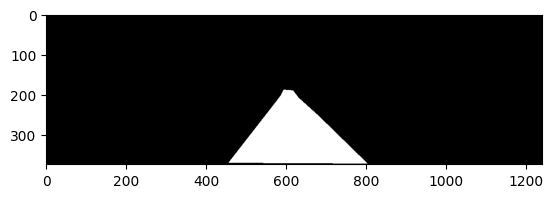

In [40]:
#read GT image and apply truth_lane
image = cv2.imread('gt_image/um_lane_000002.png')
#BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#TODO: filter the lane - truth_lane()
#code here
image_lane = truth_lane(image)

#TODO: print lane
#code here
plt.imshow(image_lane, cmap='gray')

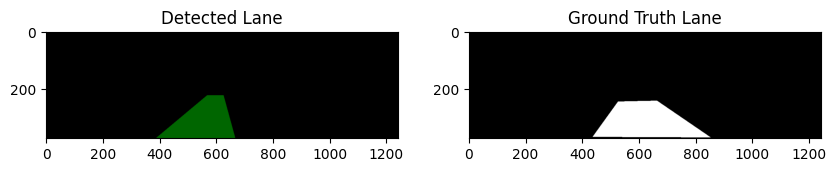

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


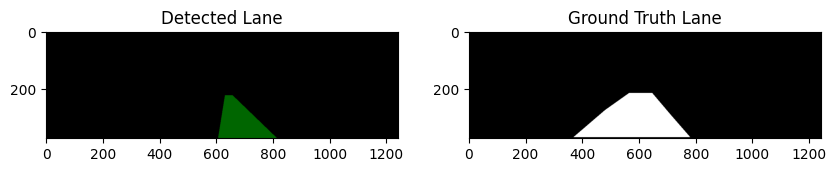

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


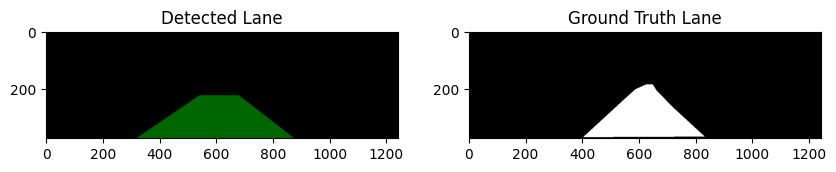

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


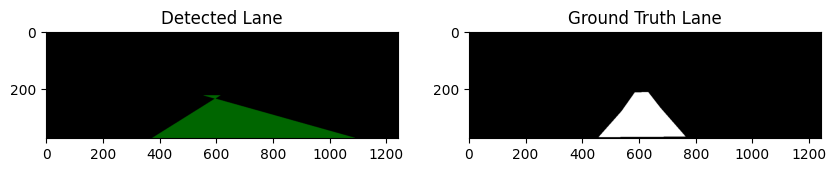

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


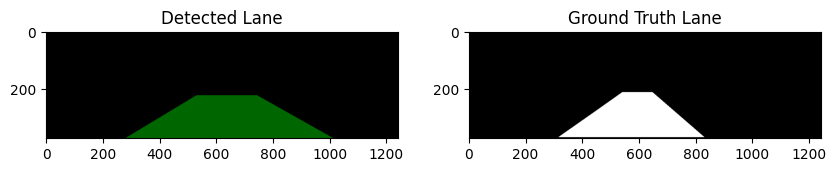

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


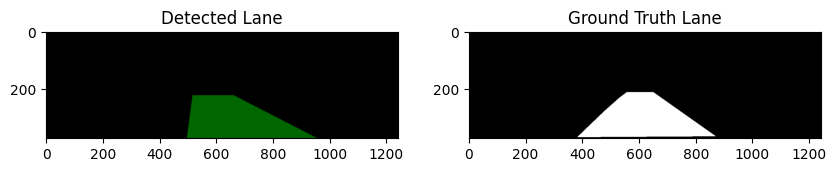

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


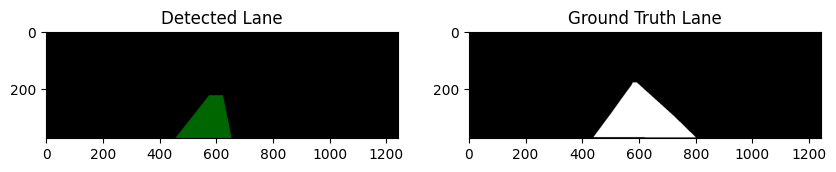

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


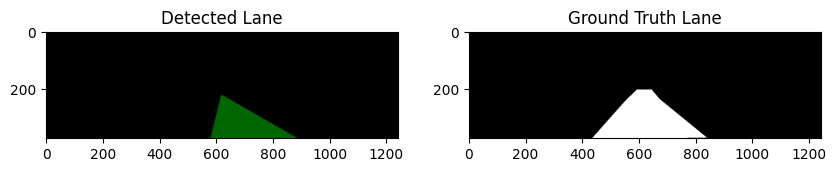

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


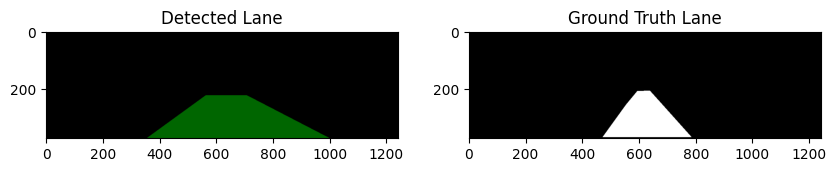

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


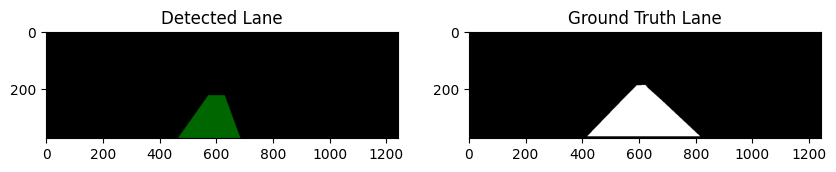

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


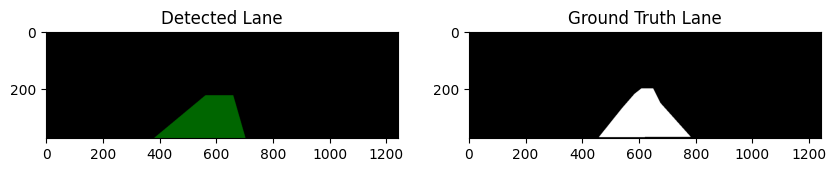

Results (accuracy, iou, precision, recall, f_measure):  (96.23982823403114, 63.599517791819096, 67.66696152145069, 91.36484428652474, 77.7502509179149)


In [49]:
iter = 0
# Iterate through the images in the folders
for image_name, gt_image_name in zip(os.listdir(image_folder_path), os.listdir(gt_folder_path)):
    if iter > 10:
        break
    # Construct full paths for the images
    image_path = os.path.join(image_folder_path, image_name)
    gt_image_path = os.path.join(gt_folder_path, gt_image_name)

    # Process images
    houghed_lines, gt_lane = process_images(image_path, gt_image_path)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(houghed_lines, cmap='gray')
    plt.title('Detected Lane')

    plt.subplot(1, 2, 2)
    plt.imshow(gt_lane, cmap='gray')
    plt.title('Ground Truth Lane')

    plt.show()

    tp, fp, tn, fn = TP_FP_TN_FN(detections, image_lane)
    print("Results (accuracy, iou, precision, recall, f_measure): ", compute_metrics(tp, fp, tn, fn))
    iter += 1